In [1]:
#setup libraries & data

#import pandas library for data analysis & manipulation
import pandas as pd
#import zipfile library to support reading zipped file into pandas dataframe
import zipfile
#import numpy library for scientific computing
import numpy as np
#import datetime library to work with time series data
import datetime as dt
#import seaborn & matplotlib libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
#for publishing graphs inside jupyter notebooks
%matplotlib inline
#import statsmodel library for statisical models & analysis
import statsmodels.api as sm

#set file path names for data sources, Kaggle prediction competition provides seven sources 
#https://www.kaggle.com/competitions/store-sales-time-series-forecasting 

#training data for model
train_path = "***Project_Data\\train.csv.zip"
#holiday/event schedule
holiday_path = "***\Project_Data\\holidays.csv"

#import data into pandas dataframe
train_data = pd.read_csv(train_path,compression="zip")
holiday_data = pd.read_csv(holiday_path)
                            
#check number of rows & columns in each set
print("training set",train_data.shape)
print("holiday calendar", holiday_data.shape)



training set (3000888, 6)
holiday calendar (350, 6)


In [2]:
holiday_data.head()

,date,type,locale,locale_name,description,transferred
0,3/2/2012,Holiday,Local,Manta,Fundacion de Manta,False
1,4/1/2012,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,4/12/2012,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,4/14/2012,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,4/21/2012,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [3]:
holiday_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [4]:
holiday_data["date"] = pd.to_datetime(holiday_data["date"],errors='coerce')
holiday_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [5]:
holiday_data.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [6]:
holiday_data["date"] = pd.to_datetime(holiday_data["date"],errors='coerce')
holiday_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [7]:
#for simplicity sake focusing on National holidays as most likely to affect sales in all stores
#per earlier exploration excluding transferred days to avoid double counting the same holiday
#also assuming work days are normal days
event_data = holiday_data.loc[(holiday_data.transferred == False) 
                              & (holiday_data.locale == "National")
                              & (holiday_data.type != "Work Day")]
event_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 14 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         161 non-null    datetime64[ns]
 1   type         161 non-null    object        
 2   locale       161 non-null    object        
 3   locale_name  161 non-null    object        
 4   description  161 non-null    object        
 5   transferred  161 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 7.7+ KB


In [8]:
event_data.head()

,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False


In [9]:
event_data = event_data.drop(["locale_name", "transferred", "type","locale"],axis=1)
event_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 14 to 349
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         161 non-null    datetime64[ns]
 1   description  161 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 3.8+ KB


In [10]:
#new noteboook, so need to perform the translation again
events_unique = pd.DataFrame(event_data.description.unique(),columns = ["Spanish"])
events_unique.head()

,Spanish
0,Primer Grito de Independencia
1,Traslado Independencia de Guayaquil
2,Dia de Difuntos
3,Independencia de Cuenca
4,Navidad-4


In [11]:
pip install googletrans==4.0.0rc1

Note: you may need to restart the kernel to use updated packages.


In [12]:
from googletrans import Translator
translator = Translator()
events_unique["English"] = events_unique["Spanish"].apply(translator.translate,src="es",dest="en").apply(getattr, args=("text",))

In [13]:
events_unique

,Spanish,English
0,Primer Grito de Independencia,FIRST GRITO OF INDEPENDENCE
1,Traslado Independencia de Guayaquil,Transfer Independence of Guayaquil
2,Dia de Difuntos,Day of the dead
3,Independencia de Cuenca,Cuenca independence
4,Navidad-4,Christmas-4
...,...,...
62,Terremoto Manabi+30,Manabi+30 earthquake
63,Traslado Batalla de Pichincha,Pichincha Battle Transfer
64,Traslado Primer Grito de Independencia,TRANSFER FIRST GRITO OF INDEPENDENCE
65,Puente Dia de Difuntos,Deceased day


In [14]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [15]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import io

C:\Users\mrmcq\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [16]:
event_names = ["Christmas","First Day of Year", "Day of the Dead","Manabi Earthquake","World Cup Brazil","Independence of Guayaquil", 
               "Mother's Day", "Pichincha Battle", "Independence of Grito", "Independence of Cuence","Black Friday", 
               "Holy Friday", "Cyber Monday","Labor Day","Carnival"]
event_names

['Christmas',
 'First Day of Year',
 'Day of the Dead',
 'Manabi Earthquake',
 'World Cup Brazil',
 'Independence of Guayaquil',
 "Mother's Day",
 'Pichincha Battle',
 'Independence of Grito',
 'Independence of Cuence',
 'Black Friday',
 'Holy Friday',
 'Cyber Monday',
 'Labor Day',
 'Carnival']

In [17]:
#the main point of this process is to standardize names
#which reduces the number of holiday features for performance
#and so the same holiday is recognized as the same event during prediction

In [18]:
events = events_unique.English.to_list()
events

['FIRST GRITO OF INDEPENDENCE',
 'Transfer Independence of Guayaquil',
 'Day of the dead',
 'Cuenca independence',
 'Christmas-4',
 'Christmas-3',
 'Christmas-2',
 'Christmas bridge',
 'Christmas-1',
 'Christmas',
 'Christmas+1',
 'First day of the anus',
 'First day 1',
 'First day of the year',
 'Carnival',
 'Holy Friday',
 'Labor Day',
 'MOTHER DAY-1',
 "Mother's Day",
 'Pichincha battle',
 'World Soccer Inauguration Brazil',
 'WORLD OF FOOTBALL BRAZIL: ECUADOR-SUIZA',
 'World Cup Brazil: Ecuador-Honduras',
 'World Cup Brazil: Ecuador-France',
 'WORLD OF FOOTBALL BRAZIL: Eighth of Final',
 'WORLD OF FOOTBALL BRAZIL: FINAL FOURTH',
 'World Cup Brazil: Semifinals',
 'World Cup Brazil: Third and fourth place',
 'World Cup Brazil: Final',
 'Black Friday',
 'Cyber Monday',
 "Guayaquil's independence",
 'Manabi earthquake',
 'Manabi+1 earthquake',
 'Manabi+2 earthquake',
 'Manabi+3 earthquake',
 'Manabi+4 earthquake',
 'Manabi+5 earthquake',
 'Manabi+6 earthquake',
 'Manabi+7 earthquake',

In [19]:
matches = []
for event in events:
    matches.append(process.extract(event, event_names, limit=1, scorer=fuzz.token_sort_ratio))


In [20]:
matches

[[('Independence of Grito', 88)],
 [('Independence of Guayaquil', 85)],
 [('Day of the Dead', 100)],
 [('Independence of Cuence', 88)],
 [('Christmas', 90)],
 [('Christmas', 90)],
 [('Christmas', 90)],
 [('Christmas', 72)],
 [('Christmas', 90)],
 [('Christmas', 100)],
 [('Christmas', 90)],
 [('First Day of Year', 74)],
 [('First Day of Year', 64)],
 [('First Day of Year', 89)],
 [('Carnival', 100)],
 [('Holy Friday', 100)],
 [('Labor Day', 100)],
 [("Mother's Day", 83)],
 [("Mother's Day", 100)],
 [('Pichincha Battle', 100)],
 [('World Cup Brazil', 58)],
 [('World Cup Brazil', 56)],
 [('World Cup Brazil', 65)],
 [('World Cup Brazil', 68)],
 [('World Cup Brazil', 46)],
 [('World Cup Brazil', 53)],
 [('World Cup Brazil', 74)],
 [('World Cup Brazil', 58)],
 [('World Cup Brazil', 84)],
 [('Black Friday', 100)],
 [('Cyber Monday', 100)],
 [('Independence of Guayaquil', 94)],
 [('Manabi Earthquake', 100)],
 [('Manabi Earthquake', 94)],
 [('Manabi Earthquake', 94)],
 [('Manabi Earthquake', 94

In [21]:
events_unique["matches"] = matches
events_unique.head()

,Spanish,English,matches
0,Primer Grito de Independencia,FIRST GRITO OF INDEPENDENCE,"[(Independence of Grito, 88)]"
1,Traslado Independencia de Guayaquil,Transfer Independence of Guayaquil,"[(Independence of Guayaquil, 85)]"
2,Dia de Difuntos,Day of the dead,"[(Day of the Dead, 100)]"
3,Independencia de Cuenca,Cuenca independence,"[(Independence of Cuence, 88)]"
4,Navidad-4,Christmas-4,"[(Christmas, 90)]"


In [22]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [23]:
from tabulate import tabulate
print(tabulate(events_unique,))

--  -----------------------------------------------  -----------------------------------------  -----------------------------------
 0  Primer Grito de Independencia                    FIRST GRITO OF INDEPENDENCE                [('Independence of Grito', 88)]
 1  Traslado Independencia de Guayaquil              Transfer Independence of Guayaquil         [('Independence of Guayaquil', 85)]
 2  Dia de Difuntos                                  Day of the dead                            [('Day of the Dead', 100)]
 3  Independencia de Cuenca                          Cuenca independence                        [('Independence of Cuence', 88)]
 4  Navidad-4                                        Christmas-4                                [('Christmas', 90)]
 5  Navidad-3                                        Christmas-3                                [('Christmas', 90)]
 6  Navidad-2                                        Christmas-2                                [('Christmas', 90)]
 7  Puen

In [24]:
#Python lists, tuples & dictionaries provide powerful ways to work with data
#but can befuddle me.  I can see the dataframe is holding some sort of mishmash of these in the matches column
#which isn't a suitable format for how we will want to use the data
#so lets see if I can extract the holiday name

In [25]:
matches[4][0][0]

'Christmas'

In [26]:
#ok, iterating through the nested list could help
match_clean = []
for i in range(0,67):
    match_clean.append(matches[i][0][0])

In [27]:
match_clean

['Independence of Grito',
 'Independence of Guayaquil',
 'Day of the Dead',
 'Independence of Cuence',
 'Christmas',
 'Christmas',
 'Christmas',
 'Christmas',
 'Christmas',
 'Christmas',
 'Christmas',
 'First Day of Year',
 'First Day of Year',
 'First Day of Year',
 'Carnival',
 'Holy Friday',
 'Labor Day',
 "Mother's Day",
 "Mother's Day",
 'Pichincha Battle',
 'World Cup Brazil',
 'World Cup Brazil',
 'World Cup Brazil',
 'World Cup Brazil',
 'World Cup Brazil',
 'World Cup Brazil',
 'World Cup Brazil',
 'World Cup Brazil',
 'World Cup Brazil',
 'Black Friday',
 'Cyber Monday',
 'Independence of Guayaquil',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi Earthquake',
 'Manabi

In [28]:
type(match_clean)

list

In [29]:
events_unique

,Spanish,English,matches
0,Primer Grito de Independencia,FIRST GRITO OF INDEPENDENCE,"[(Independence of Grito, 88)]"
1,Traslado Independencia de Guayaquil,Transfer Independence of Guayaquil,"[(Independence of Guayaquil, 85)]"
2,Dia de Difuntos,Day of the dead,"[(Day of the Dead, 100)]"
3,Independencia de Cuenca,Cuenca independence,"[(Independence of Cuence, 88)]"
4,Navidad-4,Christmas-4,"[(Christmas, 90)]"
...,...,...,...
62,Terremoto Manabi+30,Manabi+30 earthquake,"[(Manabi Earthquake, 92)]"
63,Traslado Batalla de Pichincha,Pichincha Battle Transfer,"[(Pichincha Battle, 78)]"
64,Traslado Primer Grito de Independencia,TRANSFER FIRST GRITO OF INDEPENDENCE,"[(Independence of Grito, 74)]"
65,Puente Dia de Difuntos,Deceased day,"[(Day of the Dead, 52)]"


In [30]:
#there is likely a better way to do this
#but since everything is still in the same order
#i am going to tack on the cleaned list as a new column in the dataframe
events_unique["Event"] = match_clean

In [31]:
#checking how it looks
events_unique

,Spanish,English,matches,Event
0,Primer Grito de Independencia,FIRST GRITO OF INDEPENDENCE,"[(Independence of Grito, 88)]",Independence of Grito
1,Traslado Independencia de Guayaquil,Transfer Independence of Guayaquil,"[(Independence of Guayaquil, 85)]",Independence of Guayaquil
2,Dia de Difuntos,Day of the dead,"[(Day of the Dead, 100)]",Day of the Dead
3,Independencia de Cuenca,Cuenca independence,"[(Independence of Cuence, 88)]",Independence of Cuence
4,Navidad-4,Christmas-4,"[(Christmas, 90)]",Christmas
...,...,...,...,...
62,Terremoto Manabi+30,Manabi+30 earthquake,"[(Manabi Earthquake, 92)]",Manabi Earthquake
63,Traslado Batalla de Pichincha,Pichincha Battle Transfer,"[(Pichincha Battle, 78)]",Pichincha Battle
64,Traslado Primer Grito de Independencia,TRANSFER FIRST GRITO OF INDEPENDENCE,"[(Independence of Grito, 74)]",Independence of Grito
65,Puente Dia de Difuntos,Deceased day,"[(Day of the Dead, 52)]",Day of the Dead


In [32]:
events_unique = events_unique.drop(["English", "matches"],axis=1)
events_unique.head()

,Spanish,Event
0,Primer Grito de Independencia,Independence of Grito
1,Traslado Independencia de Guayaquil,Independence of Guayaquil
2,Dia de Difuntos,Day of the Dead
3,Independencia de Cuenca,Independence of Cuence
4,Navidad-4,Christmas


In [33]:
event_data.head()

,date,description
14,2012-08-10,Primer Grito de Independencia
20,2012-10-12,Traslado Independencia de Guayaquil
21,2012-11-02,Dia de Difuntos
22,2012-11-03,Independencia de Cuenca
31,2012-12-21,Navidad-4


In [34]:
#updating the column name to provide a common key for joining
event_data.rename(columns = {"description":"Spanish"}, inplace = True)
event_data.head()

,date,Spanish
14,2012-08-10,Primer Grito de Independencia
20,2012-10-12,Traslado Independencia de Guayaquil
21,2012-11-02,Dia de Difuntos
22,2012-11-03,Independencia de Cuenca
31,2012-12-21,Navidad-4


In [35]:
#joining the cleaned & translated name to the holiday schedule
event_clean = pd.merge(event_data, events_unique, on = "Spanish", how = "outer")
event_clean

,date,Spanish,Event
0,2012-08-10,Primer Grito de Independencia,Independence of Grito
1,2013-08-10,Primer Grito de Independencia,Independence of Grito
2,2014-08-10,Primer Grito de Independencia,Independence of Grito
3,2015-08-10,Primer Grito de Independencia,Independence of Grito
4,2012-10-12,Traslado Independencia de Guayaquil,Independence of Guayaquil
...,...,...,...
156,2017-05-26,Traslado Batalla de Pichincha,Pichincha Battle
157,2016-08-12,Traslado Primer Grito de Independencia,Independence of Grito
158,2017-08-11,Traslado Primer Grito de Independencia,Independence of Grito
159,2016-11-04,Puente Dia de Difuntos,Day of the Dead


In [36]:
event_clean = event_clean.drop(["Spanish"],axis=1)
event_clean.head()

,date,Event
0,2012-08-10,Independence of Grito
1,2013-08-10,Independence of Grito
2,2014-08-10,Independence of Grito
3,2015-08-10,Independence of Grito
4,2012-10-12,Independence of Guayaquil


In [37]:
event_clean = event_clean.sort_values(by="date")
event_clean

,date,Event
0,2012-08-10,Independence of Grito
4,2012-10-12,Independence of Guayaquil
7,2012-11-02,Day of the Dead
13,2012-11-03,Independence of Cuence
19,2012-12-21,Christmas
...,...,...
30,2017-12-22,Christmas
36,2017-12-23,Christmas
44,2017-12-24,Christmas
50,2017-12-25,Christmas


In [38]:
#reviewing results
print(tabulate(event_clean))

---  -------------------  -------------------------
  0  2012-08-10 00:00:00  Independence of Grito
  4  2012-10-12 00:00:00  Independence of Guayaquil
  7  2012-11-02 00:00:00  Day of the Dead
 13  2012-11-03 00:00:00  Independence of Cuence
 19  2012-12-21 00:00:00  Christmas
 25  2012-12-22 00:00:00  Christmas
 31  2012-12-23 00:00:00  Christmas
 39  2012-12-24 00:00:00  Christmas
 37  2012-12-24 00:00:00  Christmas
 45  2012-12-25 00:00:00  Christmas
 51  2012-12-26 00:00:00  Christmas
 57  2012-12-31 00:00:00  First Day of Year
 59  2012-12-31 00:00:00  First Day of Year
 64  2013-01-01 00:00:00  First Day of Year
 68  2013-02-11 00:00:00  Carnival
 69  2013-02-12 00:00:00  Carnival
 78  2013-04-29 00:00:00  Holy Friday
 83  2013-05-01 00:00:00  Labor Day
 88  2013-05-11 00:00:00  Mother's Day
 93  2013-05-12 00:00:00  Mother's Day
 98  2013-05-24 00:00:00  Pichincha Battle
  1  2013-08-10 00:00:00  Independence of Grito
  5  2013-10-11 00:00:00  Independence of Guayaquil
  8  201

In [39]:
#I should note that standardizing names resulted in dropping all the time lags indicated in the names
#but i'm going to live with that, we'll see where that takes us

In [40]:
event_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 0 to 56
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    161 non-null    datetime64[ns]
 1   Event   161 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 3.8+ KB


In [41]:
event_clean["date"].nunique()

155

In [42]:
#uh-oh. 161 rows vs 155 unique entries tells me we have duplicate dates
#this will cause problems when we join the holiday/event schedule to the sales history
#more cleaning needed!

In [43]:
quake = event_clean[event_clean["Event"].str.contains("quake")]
quake

,date,Event
124,2016-04-16,Manabi Earthquake
125,2016-04-17,Manabi Earthquake
126,2016-04-18,Manabi Earthquake
127,2016-04-19,Manabi Earthquake
128,2016-04-20,Manabi Earthquake
129,2016-04-21,Manabi Earthquake
130,2016-04-22,Manabi Earthquake
131,2016-04-23,Manabi Earthquake
132,2016-04-24,Manabi Earthquake
133,2016-04-25,Manabi Earthquake


In [44]:
soccer= event_clean[event_clean["Event"].str.contains("Cup")]
soccer

,date,Event
101,2014-06-12,World Cup Brazil
102,2014-06-15,World Cup Brazil
103,2014-06-20,World Cup Brazil
104,2014-06-25,World Cup Brazil
105,2014-06-28,World Cup Brazil
106,2014-06-29,World Cup Brazil
107,2014-06-30,World Cup Brazil
108,2014-07-01,World Cup Brazil
109,2014-07-04,World Cup Brazil
110,2014-07-05,World Cup Brazil


In [45]:
event_clean = event_clean[~event_clean["Event"].str.contains("quake")]
event_clean

,date,Event
0,2012-08-10,Independence of Grito
4,2012-10-12,Independence of Guayaquil
7,2012-11-02,Day of the Dead
13,2012-11-03,Independence of Cuence
19,2012-12-21,Christmas
...,...,...
30,2017-12-22,Christmas
36,2017-12-23,Christmas
44,2017-12-24,Christmas
50,2017-12-25,Christmas


In [46]:
event_clean = event_clean[~event_clean["Event"].str.contains("Cup")]
event_clean

,date,Event
0,2012-08-10,Independence of Grito
4,2012-10-12,Independence of Guayaquil
7,2012-11-02,Day of the Dead
13,2012-11-03,Independence of Cuence
19,2012-12-21,Christmas
...,...,...
30,2017-12-22,Christmas
36,2017-12-23,Christmas
44,2017-12-24,Christmas
50,2017-12-25,Christmas


In [47]:
event_clean["date"].nunique()

113

In [48]:
dup_events = event_clean[event_clean.duplicated(["date"])]
dup_events

,date,Event
37,2012-12-24,Christmas
59,2012-12-31,First Day of Year
53,2014-12-26,Christmas


In [49]:
#found the duplicated dates, dropping them after reviewing tabulate detail
holiday = event_clean.drop(index=[37,59,53])

In [50]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 0 to 56
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    113 non-null    datetime64[ns]
 1   Event   113 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 2.6+ KB


In [51]:
holiday.head()

,date,Event
0,2012-08-10,Independence of Grito
4,2012-10-12,Independence of Guayaquil
7,2012-11-02,Day of the Dead
13,2012-11-03,Independence of Cuence
19,2012-12-21,Christmas


In [52]:
#finally we better start getting to know the training data!
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [53]:
train_data = train_data.drop(["id"], axis=1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 114.5+ MB


In [54]:
#data type cleanup
train_data["date"] = pd.to_datetime(train_data["date"],errors='coerce')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 114.5+ MB


In [55]:
#prefer to specify store number is a string
#otherwise code has tendency to think integers have math significance!
train_data["store_nbr"] = train_data["store_nbr"].astype(str)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    object        
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 114.5+ MB


In [56]:
#adding quake timeline to training data
#i'll be running .info() several times to double check joins work as expected (and don't duplicate rows)
train_events = pd.merge(quake, train_data, on="date", how="right")
train_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   Event        object        
 2   store_nbr    object        
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 160.3+ MB


In [57]:
train_events.tail()

,date,Event,store_nbr,family,sales,onpromotion
3000883,2017-08-15,NaN,9,POULTRY,438.133,0
3000884,2017-08-15,NaN,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,NaN,9,PRODUCE,2419.729,148
3000886,2017-08-15,NaN,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,2017-08-15,NaN,9,SEAFOOD,16.000,0


In [58]:
train_events["Event"].fillna(0, inplace=True)

In [59]:
train_events.tail()

,date,Event,store_nbr,family,sales,onpromotion
3000883,2017-08-15,0,9,POULTRY,438.133,0
3000884,2017-08-15,0,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,0,9,PRODUCE,2419.729,148
3000886,2017-08-15,0,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,2017-08-15,0,9,SEAFOOD,16.000,0


In [60]:
train_events["Event"].replace("Manabi Earthquake",1,inplace=True)
train_events.head()

,date,Event,store_nbr,family,sales,onpromotion
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0
1,2013-01-01,0,1,BABY CARE,0.0,0
2,2013-01-01,0,1,BEAUTY,0.0,0
3,2013-01-01,0,1,BEVERAGES,0.0,0
4,2013-01-01,0,1,BOOKS,0.0,0


In [61]:
train_events.rename(columns = {"Event":"quake"}, inplace = True)
train_events.head()

,date,quake,store_nbr,family,sales,onpromotion
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0
1,2013-01-01,0,1,BABY CARE,0.0,0
2,2013-01-01,0,1,BEAUTY,0.0,0
3,2013-01-01,0,1,BEVERAGES,0.0,0
4,2013-01-01,0,1,BOOKS,0.0,0


In [62]:
train_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   quake        int64         
 2   store_nbr    object        
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 160.3+ MB


In [63]:
train_events["quake"] = train_events["quake"].astype("bool")

In [64]:
train_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   quake        bool          
 2   store_nbr    object        
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 140.2+ MB


In [65]:
train_events2 = pd.merge(soccer, train_events, on="date", how="right")
train_events2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   Event        object        
 2   quake        bool          
 3   store_nbr    object        
 4   family       object        
 5   sales        float64       
 6   onpromotion  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 163.1+ MB


In [66]:
train_events2.head()

,date,Event,quake,store_nbr,family,sales,onpromotion
0,2013-01-01,NaN,False,1,AUTOMOTIVE,0.0,0
1,2013-01-01,NaN,False,1,BABY CARE,0.0,0
2,2013-01-01,NaN,False,1,BEAUTY,0.0,0
3,2013-01-01,NaN,False,1,BEVERAGES,0.0,0
4,2013-01-01,NaN,False,1,BOOKS,0.0,0


In [67]:
train_events2["Event"].fillna(0, inplace=True)
train_events2["Event"].replace("World Cup Brazil",1,inplace=True)
train_events2.rename(columns = {"Event":"world_cup"}, inplace = True)
train_events2["world_cup"] = train_events2["world_cup"].astype("bool")

In [68]:
train_events2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   world_cup    bool          
 2   quake        bool          
 3   store_nbr    object        
 4   family       object        
 5   sales        float64       
 6   onpromotion  int64         
dtypes: bool(2), datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 143.1+ MB


In [69]:
train_events3 = pd.merge(holiday, train_events2, on="date", how="right")

In [70]:
train_events3.head()

,date,Event,world_cup,quake,store_nbr,family,sales,onpromotion
0,2013-01-01,First Day of Year,False,False,1,AUTOMOTIVE,0.0,0
1,2013-01-01,First Day of Year,False,False,1,BABY CARE,0.0,0
2,2013-01-01,First Day of Year,False,False,1,BEAUTY,0.0,0
3,2013-01-01,First Day of Year,False,False,1,BEVERAGES,0.0,0
4,2013-01-01,First Day of Year,False,False,1,BOOKS,0.0,0


In [71]:
train_events3.tail()

,date,Event,world_cup,quake,store_nbr,family,sales,onpromotion
3000883,2017-08-15,NaN,False,False,9,POULTRY,438.133,0
3000884,2017-08-15,NaN,False,False,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,NaN,False,False,9,PRODUCE,2419.729,148
3000886,2017-08-15,NaN,False,False,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,2017-08-15,NaN,False,False,9,SEAFOOD,16.000,0


In [72]:
train_events3.rename(columns = {"Event":"holiday"}, inplace = True)
train_events3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   holiday      object        
 2   world_cup    bool          
 3   quake        bool          
 4   store_nbr    object        
 5   family       object        
 6   sales        float64       
 7   onpromotion  int64         
dtypes: bool(2), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 166.0+ MB


In [73]:
train_events3["holiday"].fillna("none", inplace=True)

In [74]:
holiday_check = train_events3[train_events3["holiday"].str.contains("Christmas")]
holiday_check

,date,holiday,world_cup,quake,store_nbr,family,sales,onpromotion
630828,2013-12-21,Christmas,False,False,1,AUTOMOTIVE,5.000000,0
630829,2013-12-21,Christmas,False,False,1,BABY CARE,0.000000,0
630830,2013-12-21,Christmas,False,False,1,BEAUTY,1.000000,0
630831,2013-12-21,Christmas,False,False,1,BEVERAGES,1265.000000,0
630832,2013-12-21,Christmas,False,False,1,BOOKS,0.000000,0
...,...,...,...,...,...,...,...,...
2587459,2016-12-26,Christmas,False,False,9,POULTRY,704.269960,0
2587460,2016-12-26,Christmas,False,False,9,PREPARED FOODS,105.548996,2
2587461,2016-12-26,Christmas,False,False,9,PRODUCE,2030.049000,3
2587462,2016-12-26,Christmas,False,False,9,SCHOOL AND OFFICE SUPPLIES,0.000000,0


In [75]:
holiday_check = train_events3[train_events3["holiday"].str.contains("Dead")]
holiday_check

,date,holiday,world_cup,quake,store_nbr,family,sales,onpromotion
543510,2013-11-02,Day of the Dead,False,False,1,AUTOMOTIVE,4.000,0
543511,2013-11-02,Day of the Dead,False,False,1,BABY CARE,0.000,0
543512,2013-11-02,Day of the Dead,False,False,1,BEAUTY,2.000,0
543513,2013-11-02,Day of the Dead,False,False,1,BEVERAGES,1030.000,0
543514,2013-11-02,Day of the Dead,False,False,1,BOOKS,0.000,0
...,...,...,...,...,...,...,...,...
2496577,2016-11-04,Day of the Dead,False,False,9,POULTRY,566.242,0
2496578,2016-11-04,Day of the Dead,False,False,9,PREPARED FOODS,123.090,0
2496579,2016-11-04,Day of the Dead,False,False,9,PRODUCE,1401.963,0
2496580,2016-11-04,Day of the Dead,False,False,9,SCHOOL AND OFFICE SUPPLIES,0.000,0


In [76]:
train_events3.holiday.unique()

array(['First Day of Year', 'none', 'Carnival', 'Holy Friday',
       'Labor Day', "Mother's Day", 'Pichincha Battle',
       'Independence of Grito', 'Independence of Guayaquil',
       'Day of the Dead', 'Independence of Cuence', 'Christmas',
       'Black Friday', 'Cyber Monday'], dtype=object)

In [77]:
#for performance reasons, returning to condensed data sets

In [78]:
sales_2016 = train_events3.loc[train_events3["date"].dt.year == 2016]

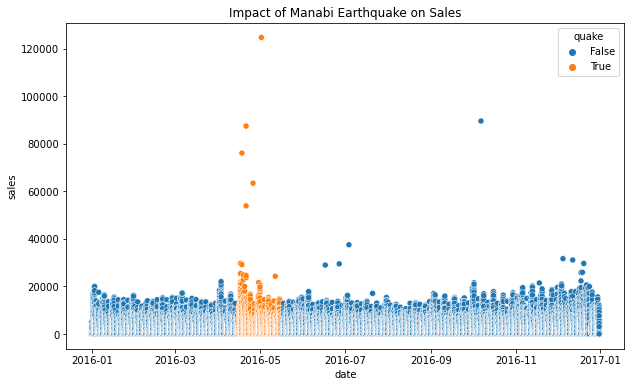

In [79]:
plt.figure(figsize=(10,6))
plt.title("Impact of Manabi Earthquake on Sales")
ax = sns.scatterplot(x=sales_2016["date"],y=sales_2016["sales"],hue=sales_2016["quake"])

In [80]:
sales_all = train_events3.groupby(["date","holiday","world_cup","quake","family"]).agg(sales_sum = ("sales", np.sum),
                                                                                      onpromo_sum = ("onpromotion", np.sum)).reset_index()
  

In [81]:
sales_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55572 entries, 0 to 55571
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         55572 non-null  datetime64[ns]
 1   holiday      55572 non-null  object        
 2   world_cup    55572 non-null  bool          
 3   quake        55572 non-null  bool          
 4   family       55572 non-null  object        
 5   sales_sum    55572 non-null  float64       
 6   onpromo_sum  55572 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 2.2+ MB


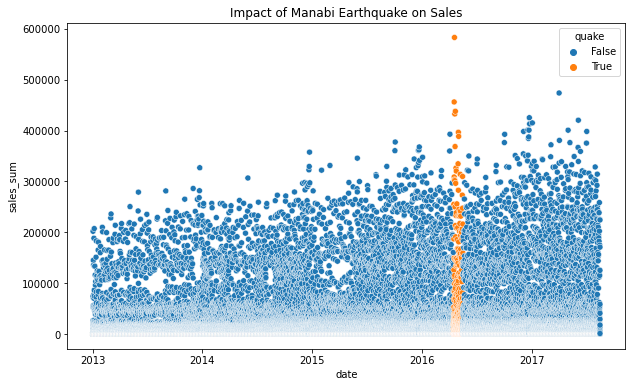

In [82]:
plt.figure(figsize=(10,6))
plt.title("Impact of Manabi Earthquake on Sales")
ax = sns.scatterplot(x=sales_all["date"],y=sales_all["sales_sum"],hue=sales_all["quake"])

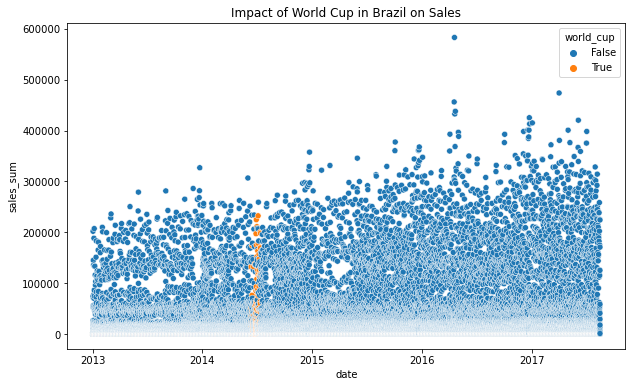

In [83]:
plt.figure(figsize=(10,6))
plt.title("Impact of World Cup in Brazil on Sales")
ax = sns.scatterplot(x=sales_all["date"],y=sales_all["sales_sum"],hue=sales_all["world_cup"])

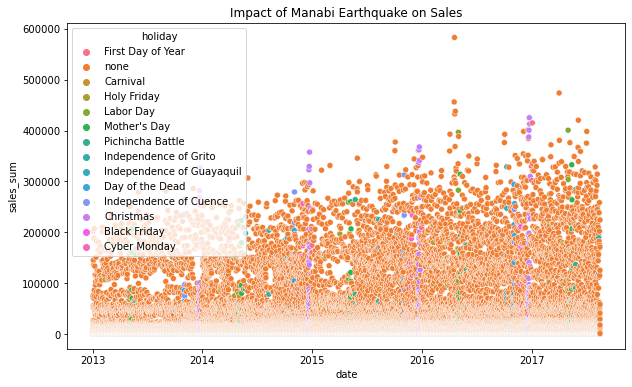

In [84]:
plt.figure(figsize=(10,6))
plt.title("Impact of Manabi Earthquake on Sales")
ax = sns.scatterplot(x=sales_all["date"],y=sales_all["sales_sum"],hue=sales_all["holiday"])

In [85]:
#wow, that's a lot of orange!
#and the default legend placement is problematic
#fortunately seaborn offers plenty of options to fine tune!

In [86]:
holiday_colors = {"First Day of Year": "#00ffff", 
                  "none": "#929591", 
                  "Carnival": "#9a0eea", 
                  "Holy Friday": "#ffff14",
                  "Labor Day": "#15b01a", 
                  "Mother's Day": "#ff81c0", 
                  "Pichincha Battle":"#e50000", 
                  "Independence of Grito":"#0343df", 
                  "Independence of Guayaquil":"#0504aa",
                  "Day of the Dead":"#f97306", 
                  "Independence of Cuence":"#75bbfd",
                  "Christmas":"#01ff07", 
                  "Black Friday":"#000000", 
                  "Cyber Monday":"#c79fef"}

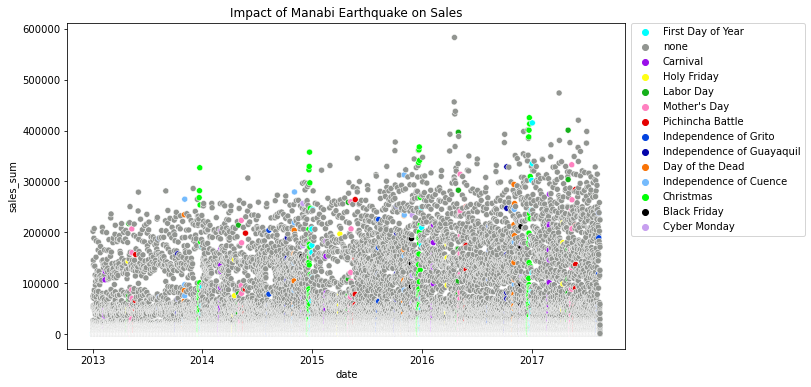

In [87]:
sns.color_palette()
plt.figure(figsize=(10,6))
plt.title("Impact of Manabi Earthquake on Sales")
ax = sns.scatterplot(data = sales_all, x="date", y="sales_sum", hue="holiday", palette = holiday_colors)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

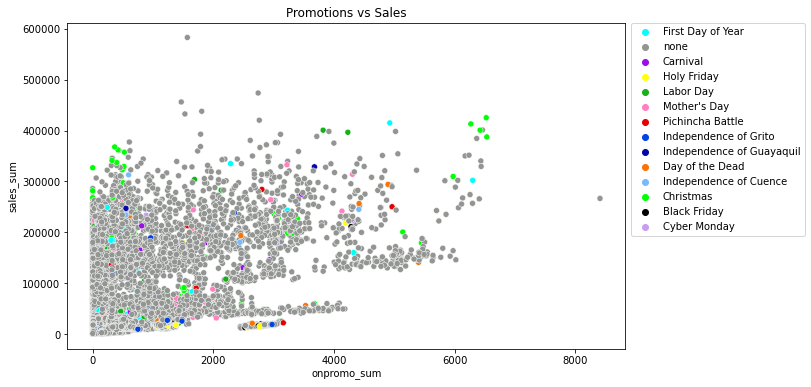

In [88]:
plt.figure(figsize=(10,6))
plt.title("Promotions vs Sales")
ax = sns.scatterplot(data = sales_all, x="onpromo_sum", y="sales_sum", hue="holiday", palette = holiday_colors)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

In [90]:
#back to the daily detail for a review of family
train_events3.head()

,date,holiday,world_cup,quake,store_nbr,family,sales,onpromotion
0,2013-01-01,First Day of Year,False,False,1,AUTOMOTIVE,0.0,0
1,2013-01-01,First Day of Year,False,False,1,BABY CARE,0.0,0
2,2013-01-01,First Day of Year,False,False,1,BEAUTY,0.0,0
3,2013-01-01,First Day of Year,False,False,1,BEVERAGES,0.0,0
4,2013-01-01,First Day of Year,False,False,1,BOOKS,0.0,0


In [94]:
sales_sort = train_events3.sort_values(by="sales", ascending=False)
sales_sort.head(20)

,date,holiday,world_cup,quake,store_nbr,family,sales,onpromotion
2163723,2016-05-02,none,False,True,2,GROCERY I,124717.000,59
2445984,2016-10-07,none,False,False,39,MEATS,89576.360,0
2144154,2016-04-21,none,False,True,20,GROCERY I,87438.516,53
2139699,2016-04-18,none,False,True,45,GROCERY I,76090.000,38
2153031,2016-04-26,none,False,True,2,GROCERY I,63434.000,30
2145045,2016-04-21,none,False,True,45,GROCERY I,53874.000,44
562596,2013-11-12,none,False,False,44,GROCERY I,46271.000,0
1257246,2014-12-08,none,False,False,35,GROCERY I,45361.000,3
1916586,2015-12-14,none,False,False,35,GROCERY I,40351.460,7
2760297,2017-04-02,none,False,False,9,GROCERY I,38422.625,73


In [106]:
sales_sort_m = sales_sort.loc[sales_sort.family == "MEATS"]
sales_sort_m.head(20)

,date,holiday,world_cup,quake,store_nbr,family,sales,onpromotion
2445984,2016-10-07,none,False,False,39,MEATS,89576.3600,0
2455719,2016-10-13,none,False,False,12,MEATS,11609.5570,17
25467,2013-01-15,none,False,False,23,MEATS,6201.7220,0
2006820,2016-02-04,none,False,False,17,MEATS,5519.7890,16
2171556,2016-05-06,none,False,True,39,MEATS,5519.3520,0
2355102,2016-08-17,none,False,False,39,MEATS,5474.6290,0
2159082,2016-04-29,none,False,True,39,MEATS,5312.5150,1
2319462,2016-07-28,none,False,False,39,MEATS,5249.7603,19
269601,2013-06-01,none,False,False,23,MEATS,5206.9510,0
2333718,2016-08-05,none,False,False,39,MEATS,5177.5710,0


In [ ]:
#wow store #39 sell a lot of meat! Oct 16 is clearly an outlier.
#that's the little blue dot way off by itself in the graph of 2016 sales.
#likely this value should be excluded.